In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/MediaPipe/

/content/drive/MyDrive/MediaPipe


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split

# CSVファイルの読み込み
data = pd.read_csv('model/action_classifier/merged_data_sample.csv')

# 先頭行を消去
data = data.iloc[1:]

# タイムスタンプ列を除去（もし存在する場合）
if 'timestamp' in data.columns:
    data = data.drop(['timestamp'], axis=1)

# 正解ラベルを一列目から取得
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

In [30]:
y.shape

(1649,)

In [31]:
X.shape

(1649, 106)

In [32]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [17]:
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(0, len(X) - sequence_length + 1, sequence_length):
        X_seq = X[i:i+sequence_length]
        y_seq = y[i:i+sequence_length]
        if len(X_seq) == sequence_length:
            sequences_X.append(X_seq)
            sequences_y.append(y_seq[0])  # 各シーケンスに一つのラベルを付与
    return np.array(sequences_X), np.array(sequences_y)

In [33]:
sequence_length = 25  # 固定長を決定
X_sequences, y_sequences = create_sequences(X, y_categorical, sequence_length)

# 訓練データとテストデータの分割
train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

In [34]:
X_sequences.shape

(65, 25, 106)

In [35]:
y_sequences.shape

(65, 3)

In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
  tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [40]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                31400     
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 31553 (123.25 KB)
Trainable params: 31553 (123.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/100
1/1 [==============================] - 0s 113ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.1033 - val_accuracy: 0.0769
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.1013 - val_accuracy: 0.0769
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.0992 - val_accuracy: 0.0769
Epoch 4/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.0972 - val_accuracy: 0.0769
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.0951 - val_accuracy: 0.0769
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.0930 - val_accuracy: 0.0769
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 153.0910 

In [58]:
# モデルの評価
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 43ms/step - loss: 152.9104 - accuracy: 0.0769
Test Loss: 152.91036987304688, Test Accuracy: 0.07692307978868484


In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

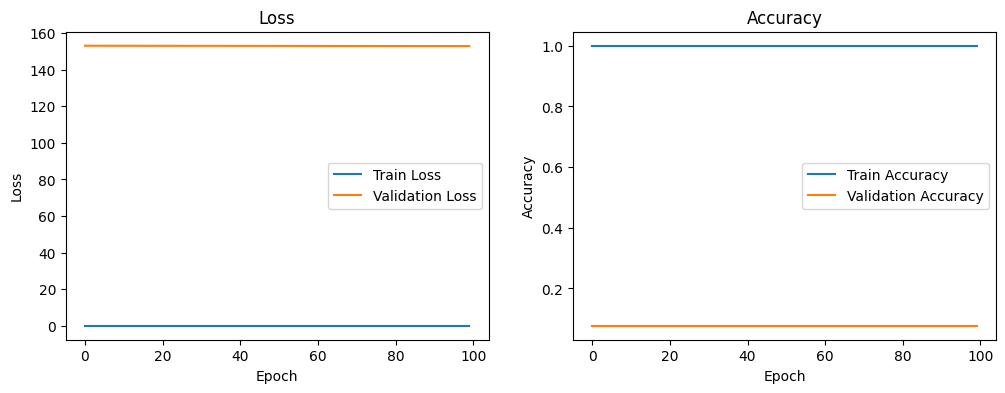

1/1 [==============================] - 0s 216ms/step


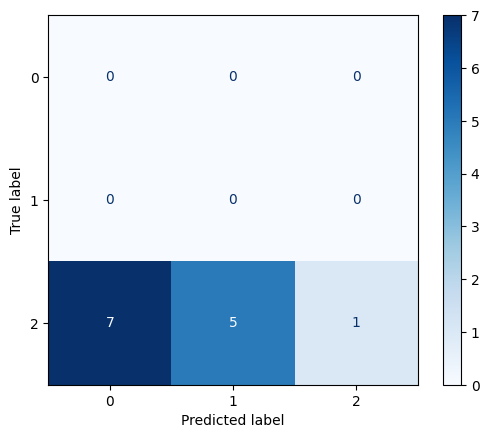

In [60]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 混同行列の表示
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()